### Installation

### Create Dataset Instance

In [1]:
import magic_pdf
import os
from magic_pdf.data.data_reader_writer import FileBasedDataWriter, FileBasedDataReader
from magic_pdf.data.dataset import PymuDocDataset
from magic_pdf.config.enums import SupportedPdfParseMethod
import time

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from magic_pdf.data.data_reader_writer import FileBasedDataWriter, FileBasedDataReader
from magic_pdf.data.dataset import PymuDocDataset

In [3]:
pdf_file_name = "demo2.pdf"
# read bytes
reader1 = FileBasedDataReader("")
pdf_bytes = reader1.read(pdf_file_name)  # read the pdf content

In [4]:
## Create Dataset Instance
ds = PymuDocDataset(pdf_bytes)

2025-05-06 07:19:05.230 | INFO     | magic_pdf.data.dataset:__init__:157 - lang: None


### exploring the dataset instance

In [ ]:
# exploration of the first page of the dataset(ds)

page_data = ds.get_page(3)
img_dict = page_data.get_image()
img = img_dict['img']
page_width = img_dict['width']
page_height = img_dict['height']

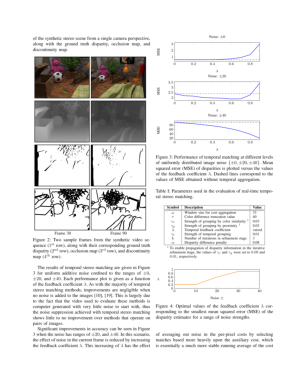

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## Models

#### layout model

In [ ]:
from ultralytics import YOLO

class DocLayoutYOLOModel(object):
    def __init__(self, weight, device):
        self.model = YOLO(weight)
        self.device = device

    def predict(self, image):
        layout_res = []
        doclayout_yolo_res = self.model.predict(
            image,
            imgsz=1280,
            conf=0.10,
            iou=0.45,
            verbose=False, device=self.device
        )[0]
        for xyxy, conf, cla in zip(
            doclayout_yolo_res.boxes.xyxy.cpu(),
            doclayout_yolo_res.boxes.conf.cpu(),
            doclayout_yolo_res.boxes.cls.cpu(),
        ):
            xmin, ymin, xmax, ymax = [int(p.item()) for p in xyxy]
            new_item = {
                "category_id": int(cla.item()),
                "poly": [xmin, ymin, xmax, ymin, xmax, ymax, xmin, ymax],
                "score": round(float(conf.item()), 3),
            }
            layout_res.append(new_item)
        return layout_res

    def batch_predict(self, images: list, batch_size: int) -> list:
        images_layout_res = []
        for index in range(0, len(images), batch_size):
            doclayout_yolo_res = [
                image_res.cpu()
                for image_res in self.model.predict(
                    images[index : index + batch_size],
                    imgsz=1280,
                    conf=0.10,
                    iou=0.45,
                    verbose=False,
                    device=self.device,
                )
            ]
            for image_res in doclayout_yolo_res:
                layout_res = []
                for xyxy, conf, cla in zip(
                    image_res.boxes.xyxy,
                    image_res.boxes.conf,
                    image_res.boxes.cls,
                ):
                    xmin, ymin, xmax, ymax = [int(p.item()) for p in xyxy]
                    new_item = {
                        "category_id": int(cla.item()),
                        "poly": [xmin, ymin, xmax, ymin, xmax, ymax, xmin, ymax],
                        "score": round(float(conf.item()), 3),
                    }
                    layout_res.append(new_item)
                images_layout_res.append(layout_res)

        return images_layout_res

#### Formula model

In [ ]:
from ultralytics import YOLO


class YOLOv8MFDModel(object):
    def __init__(self, weight, device="cpu"):
        self.mfd_model = YOLO(weight)
        self.device = device

    def predict(self, image):
        mfd_res = self.mfd_model.predict(
            image, imgsz=1888, conf=0.25, iou=0.45, verbose=False, device=self.device
        )[0]
        return mfd_res

    def batch_predict(self, images: list, batch_size: int) -> list:
        images_mfd_res = []
        for index in range(0, len(images), batch_size):
            mfd_res = [
                image_res.cpu()
                for image_res in self.mfd_model.predict(
                    images[index : index + batch_size],
                    imgsz=1888,
                    conf=0.25,
                    iou=0.45,
                    verbose=False,
                    device=self.device,
                )
            ]
            for image_res in mfd_res:
                images_mfd_res.append(image_res)
        return images_mfd_res

#### mfr

In [ ]:
import argparse
import os
import re

import torch
import unimernet.tasks as tasks
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from unimernet.common.config import Config
from unimernet.processors import load_processor


class MathDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # if not pil image, then convert to pil image
        if isinstance(self.image_paths[idx], str):
            raw_image = Image.open(self.image_paths[idx])
        else:
            raw_image = self.image_paths[idx]
        if self.transform:
            image = self.transform(raw_image)
            return image


def latex_rm_whitespace(s: str):
    """Remove unnecessary whitespace from LaTeX code."""
    text_reg = r"(\\(operatorname|mathrm|text|mathbf)\s?\*? {.*?})"
    letter = "[a-zA-Z]"
    noletter = "[\W_^\d]"
    names = [x[0].replace(" ", "") for x in re.findall(text_reg, s)]
    s = re.sub(text_reg, lambda match: str(names.pop(0)), s)
    news = s
    while True:
        s = news
        news = re.sub(r"(?!\\ )(%s)\s+?(%s)" % (noletter, noletter), r"\1\2", s)
        news = re.sub(r"(?!\\ )(%s)\s+?(%s)" % (noletter, letter), r"\1\2", news)
        news = re.sub(r"(%s)\s+?(%s)" % (letter, noletter), r"\1\2", news)
        if news == s:
            break
    return s


class UnimernetModel(object):
    def __init__(self, weight_dir, cfg_path, _device_="cpu"):
        args = argparse.Namespace(cfg_path=cfg_path, options=None)
        cfg = Config(args)
        cfg.config.model.pretrained = os.path.join(weight_dir, "pytorch_model.pth")
        cfg.config.model.model_config.model_name = weight_dir
        cfg.config.model.tokenizer_config.path = weight_dir
        task = tasks.setup_task(cfg)
        self.model = task.build_model(cfg)
        self.device = _device_
        self.model.to(_device_)
        self.model.eval()
        vis_processor = load_processor(
            "formula_image_eval",
            cfg.config.datasets.formula_rec_eval.vis_processor.eval,
        )
        self.mfr_transform = transforms.Compose(
            [
                vis_processor,
            ]
        )

    def predict(self, mfd_res, image):
        formula_list = []
        mf_image_list = []
        for xyxy, conf, cla in zip(
            mfd_res.boxes.xyxy.cpu(), mfd_res.boxes.conf.cpu(), mfd_res.boxes.cls.cpu()
        ):
            xmin, ymin, xmax, ymax = [int(p.item()) for p in xyxy]
            new_item = {
                "category_id": 13 + int(cla.item()),
                "poly": [xmin, ymin, xmax, ymin, xmax, ymax, xmin, ymax],
                "score": round(float(conf.item()), 2),
                "latex": "",
            }
            formula_list.append(new_item)
            pil_img = Image.fromarray(image)
            bbox_img = pil_img.crop((xmin, ymin, xmax, ymax))
            mf_image_list.append(bbox_img)

        dataset = MathDataset(mf_image_list, transform=self.mfr_transform)
        dataloader = DataLoader(dataset, batch_size=32, num_workers=0)
        mfr_res = []
        for mf_img in dataloader:
            mf_img = mf_img.to(self.device)
            with torch.no_grad():
                output = self.model.generate({"image": mf_img})
            mfr_res.extend(output["pred_str"])
        for res, latex in zip(formula_list, mfr_res):
            res["latex"] = latex_rm_whitespace(latex)
        return formula_list

    def batch_predict(
        self, images_mfd_res: list, images: list, batch_size: int = 64
    ) -> list:
        images_formula_list = []
        mf_image_list = []
        backfill_list = []
        for image_index in range(len(images_mfd_res)):
            mfd_res = images_mfd_res[image_index]
            pil_img = Image.fromarray(images[image_index])
            formula_list = []

            for xyxy, conf, cla in zip(
                mfd_res.boxes.xyxy, mfd_res.boxes.conf, mfd_res.boxes.cls
            ):
                xmin, ymin, xmax, ymax = [int(p.item()) for p in xyxy]
                new_item = {
                    "category_id": 13 + int(cla.item()),
                    "poly": [xmin, ymin, xmax, ymin, xmax, ymax, xmin, ymax],
                    "score": round(float(conf.item()), 2),
                    "latex": "",
                }
                formula_list.append(new_item)
                bbox_img = pil_img.crop((xmin, ymin, xmax, ymax))
                mf_image_list.append(bbox_img)

            images_formula_list.append(formula_list)
            backfill_list += formula_list

        dataset = MathDataset(mf_image_list, transform=self.mfr_transform)
        dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0)
        mfr_res = []
        for mf_img in dataloader:
            mf_img = mf_img.to(self.device)
            with torch.no_grad():
                output = self.model.generate({"image": mf_img})
            mfr_res.extend(output["pred_str"])
        for res, latex in zip(backfill_list, mfr_res):
            res["latex"] = latex_rm_whitespace(latex)
        return images_formula_list

#### ocr

In [ ]:
from paddleocr.ppocr.utils.logging import get_logger

In [ ]:
from magic_pdf.model.sub_modules.ocr.paddleocr.ocr_utils import update_det_boxes, merge_det_boxes, check_img, \
    ONNXModelSingleton

In [ ]:
import copy
import platform
import time
import cv2
import numpy as np
import torch

from paddleocr import PaddleOCR
from paddleocr.ppocr.utils.logging import get_logger
from paddleocr.ppocr.utils.utility import alpha_to_color, binarize_img
from paddleocr.tools.infer.predict_system import sorted_boxes
from paddleocr.tools.infer.utility import get_rotate_crop_image, get_minarea_rect_crop

from magic_pdf.model.sub_modules.ocr.paddleocr.ocr_utils import update_det_boxes, merge_det_boxes, check_img, \
    ONNXModelSingleton

logger = get_logger()


class ModifiedPaddleOCR(PaddleOCR):
    def __init__(self, *args, **kwargs):

        super().__init__(*args, **kwargs)
        self.lang = kwargs.get('lang', 'ch')
        # 在cpu架构为arm且不支持cuda时调用onnx、
        if not torch.cuda.is_available() and platform.machine() in ['arm64', 'aarch64']:
            self.use_onnx = True
            onnx_model_manager = ONNXModelSingleton()
            self.additional_ocr = onnx_model_manager.get_onnx_model(**kwargs)
        else:
            self.use_onnx = False

    def ocr(self,
            img,
            det=True,
            rec=True,
            cls=True,
            bin=False,
            inv=False,
            alpha_color=(255, 255, 255),
            mfd_res=None,
            ):
        """
        OCR with PaddleOCR
        args：
            img: img for OCR, support ndarray, img_path and list or ndarray
            det: use text detection or not. If False, only rec will be exec. Default is True
            rec: use text recognition or not. If False, only det will be exec. Default is True
            cls: use angle classifier or not. Default is True. If True, the text with rotation of 180 degrees can be recognized. If no text is rotated by 180 degrees, use cls=False to get better performance. Text with rotation of 90 or 270 degrees can be recognized even if cls=False.
            bin: binarize image to black and white. Default is False.
            inv: invert image colors. Default is False.
            alpha_color: set RGB color Tuple for transparent parts replacement. Default is pure white.
        """
        assert isinstance(img, (np.ndarray, list, str, bytes))
        if isinstance(img, list) and det == True:
            logger.error('When input a list of images, det must be false')
            exit(0)
        if cls == True and self.use_angle_cls == False:
            pass
            # logger.warning(
            #     'Since the angle classifier is not initialized, it will not be used during the forward process'
            # )

        img = check_img(img)
        # for infer pdf file
        if isinstance(img, list):
            if self.page_num > len(img) or self.page_num == 0:
                self.page_num = len(img)
            imgs = img[:self.page_num]
        else:
            imgs = [img]

        def preprocess_image(_image):
            _image = alpha_to_color(_image, alpha_color)
            if inv:
                _image = cv2.bitwise_not(_image)
            if bin:
                _image = binarize_img(_image)
            return _image

        if det and rec:
            ocr_res = []
            for img in imgs:
                img = preprocess_image(img)
                dt_boxes, rec_res, _ = self.__call__(img, cls, mfd_res=mfd_res)
                if not dt_boxes and not rec_res:
                    ocr_res.append(None)
                    continue
                tmp_res = [[box.tolist(), res]
                           for box, res in zip(dt_boxes, rec_res)]
                ocr_res.append(tmp_res)
            return ocr_res
        elif det and not rec:
            ocr_res = []
            for img in imgs:
                img = preprocess_image(img)
                if self.lang in ['ch'] and self.use_onnx:
                    dt_boxes, elapse = self.additional_ocr.text_detector(img)
                else:
                    dt_boxes, elapse = self.text_detector(img)
                if dt_boxes is None:
                    ocr_res.append(None)
                    continue
                dt_boxes = sorted_boxes(dt_boxes)
                # merge_det_boxes 和 update_det_boxes 都会把poly转成bbox再转回poly，因此需要过滤所有倾斜程度较大的文本框
                dt_boxes = merge_det_boxes(dt_boxes)
                if mfd_res:
                    bef = time.time()
                    dt_boxes = update_det_boxes(dt_boxes, mfd_res)
                    aft = time.time()
                    logger.debug("split text box by formula, new dt_boxes num : {}, elapsed : {}".format(
                        len(dt_boxes), aft - bef))
                tmp_res = [box.tolist() for box in dt_boxes]
                ocr_res.append(tmp_res)
            return ocr_res
        else:
            ocr_res = []
            cls_res = []
            for img in imgs:
                if not isinstance(img, list):
                    img = preprocess_image(img)
                    img = [img]
                if self.use_angle_cls and cls:
                    img, cls_res_tmp, elapse = self.text_classifier(img)
                    if not rec:
                        cls_res.append(cls_res_tmp)
                if self.lang in ['ch'] and self.use_onnx:
                    rec_res, elapse = self.additional_ocr.text_recognizer(img)
                else:
                    rec_res, elapse = self.text_recognizer(img)
                ocr_res.append(rec_res)
            if not rec:
                return cls_res
            return ocr_res

    def __call__(self, img, cls=True, mfd_res=None):
        time_dict = {'det': 0, 'rec': 0, 'cls': 0, 'all': 0}

        if img is None:
            logger.debug("no valid image provided")
            return None, None, time_dict

        start = time.time()
        ori_im = img.copy()
        if self.lang in ['ch'] and self.use_onnx:
            dt_boxes, elapse = self.additional_ocr.text_detector(img)
        else:
            dt_boxes, elapse = self.text_detector(img)
        time_dict['det'] = elapse

        if dt_boxes is None:
            logger.debug("no dt_boxes found, elapsed : {}".format(elapse))
            end = time.time()
            time_dict['all'] = end - start
            return None, None, time_dict
        else:
            logger.debug("dt_boxes num : {}, elapsed : {}".format(
                len(dt_boxes), elapse))
        img_crop_list = []

        dt_boxes = sorted_boxes(dt_boxes)

        # merge_det_boxes 和 update_det_boxes 都会把poly转成bbox再转回poly，因此需要过滤所有倾斜程度较大的文本框
        dt_boxes = merge_det_boxes(dt_boxes)

        if mfd_res:
            bef = time.time()
            dt_boxes = update_det_boxes(dt_boxes, mfd_res)
            aft = time.time()
            logger.debug("split text box by formula, new dt_boxes num : {}, elapsed : {}".format(
                len(dt_boxes), aft - bef))

        for bno in range(len(dt_boxes)):
            tmp_box = copy.deepcopy(dt_boxes[bno])
            if self.args.det_box_type == "quad":
                img_crop = get_rotate_crop_image(ori_im, tmp_box)
            else:
                img_crop = get_minarea_rect_crop(ori_im, tmp_box)
            img_crop_list.append(img_crop)
        if self.use_angle_cls and cls:
            img_crop_list, angle_list, elapse = self.text_classifier(
                img_crop_list)
            time_dict['cls'] = elapse
            logger.debug("cls num  : {}, elapsed : {}".format(
                len(img_crop_list), elapse))
        if self.lang in ['ch'] and self.use_onnx:
            rec_res, elapse = self.additional_ocr.text_recognizer(img_crop_list)
        else:
            rec_res, elapse = self.text_recognizer(img_crop_list)
        time_dict['rec'] = elapse
        logger.debug("rec_res num  : {}, elapsed : {}".format(
            len(rec_res), elapse))
        if self.args.save_crop_res:
            self.draw_crop_rec_res(self.args.crop_res_save_dir, img_crop_list,
                                   rec_res)
        filter_boxes, filter_rec_res = [], []
        for box, rec_result in zip(dt_boxes, rec_res):
            text, score = rec_result
            if score >= self.drop_score:
                filter_boxes.append(box)
                filter_rec_res.append(rec_result)
        end = time.time()
        time_dict['all'] = end - start
        return filter_boxes, filter_rec_res, time_dict

In [ ]:
from model_utils import *

#### table

In [ ]:
from table_utils import *

In [ ]:
!pip install struct_eqtable

In [ ]:
import torch
from struct_eqtable import build_model

from magic_pdf.model.sub_modules.table.table_utils import minify_html


class StructTableModel:
    def __init__(self, model_path, max_new_tokens=1024, max_time=60):
        # init
        assert torch.cuda.is_available(), "CUDA must be available for StructEqTable model."
        self.model = build_model(
            model_ckpt=model_path,
            max_new_tokens=max_new_tokens,
            max_time=max_time,
            lmdeploy=False,
            flash_attn=False,
            batch_size=1,
        ).cuda()
        self.default_format = "html"

    def predict(self, images, output_format=None, **kwargs):

        if output_format is None:
            output_format = self.default_format
        else:
            if output_format not in ['latex', 'markdown', 'html']:
                raise ValueError(f"Output format {output_format} is not supported.")

        results = self.model(
            images, output_format=output_format
        )

        if output_format == "html":
            results = [minify_html(html) for html in results]

        return results

import tensorrt_llm failed, if do not use tensorrt, ignore this message
import lmdeploy failed, if do not use lmdeploy, ignore this message


## Full Inference Pipeline MOB

In [ ]:
from loguru import logger

In [ ]:
model_json = [] # the json that puts the results for each page

In [ ]:
dataset = ds
start_page_id = 0
end_page_id = None
end_page_id = end_page_id if end_page_id else len(dataset) - 1


for index in range(len(dataset)):
  page_data = dataset.get_page(index)
  img_dict = page_data.get_image()
  img = img_dict['img']
  page_width = img_dict['width']
  page_height = img_dict['height']
  if start_page_id <= index <= end_page_id:
    page_start = time.time()
    result = custom_model(img)
    logger.info(f'-----page_id : {index}, page total time: {round(time.time() - page_start, 2)}-----')
  else:
      result = []

  page_info = {'page_no': index, 'height': page_height, 'width': page_width}
  page_dict = {'layout_dets': result, 'page_info': page_info}
  model_json.append(page_dict)

2025-02-21 07:47:12.206 | INFO     | __main__:custom_model:12 - layout detection time: 2.58
2025-02-21 07:47:18.152 | INFO     | __main__:custom_model:18 - mfd time: 5.94


CustomVisionEncoderDecoderModel init
VariableUnimerNetModel init
VariableUnimerNetPatchEmbeddings init
VariableUnimerNetModel init
VariableUnimerNetPatchEmbeddings init
CustomMBartForCausalLM init
CustomMBartDecoder init


2025-02-21 07:47:48.174 | INFO     | __main__:custom_model:25 - formula nums: 2, mfr time: 30.02
2025-02-21 07:47:50.366 | DEBUG    | __main__:__call__:157 - dt_boxes num : 11, elapsed : 0.3561885356903076
2025-02-21 07:47:52.107 | DEBUG    | __main__:__call__:191 - rec_res num  : 11, elapsed : 1.7219862937927246
2025-02-21 07:47:52.109 | INFO     | __main__:custom_model:63 - ocr time: 3.93
2025-02-21 07:47:55.534 | INFO     | __main__:custom_model:109 - table time: 0.0
2025-02-21 07:47:55.956 | DEBUG    | __main__:__call__:157 - dt_boxes num : 12, elapsed : 0.4183344841003418
2025-02-21 07:48:00.327 | DEBUG    | __main__:__call__:191 - rec_res num  : 12, elapsed : 4.351718902587891
2025-02-21 07:48:00.338 | INFO     | __main__:custom_model:63 - ocr time: 12.16
2025-02-21 07:48:02.829 | INFO     | __main__:custom_model:109 - table time: 0.0
2025-02-21 07:48:02.940 | DEBUG    | __main__:__call__:157 - dt_boxes num : 11, elapsed : 0.10595083236694336
2025-02-21 07:48:04.407 | DEBUG    | 

CustomVisionEncoderDecoderModel init
VariableUnimerNetModel init
VariableUnimerNetPatchEmbeddings init
VariableUnimerNetModel init
VariableUnimerNetPatchEmbeddings init
CustomMBartForCausalLM init
CustomMBartDecoder init


2025-02-21 07:51:36.761 | INFO     | __main__:custom_model:25 - formula nums: 27, mfr time: 94.18
2025-02-21 07:51:38.977 | DEBUG    | __main__:__call__:157 - dt_boxes num : 12, elapsed : 0.6326041221618652
2025-02-21 07:51:40.717 | DEBUG    | __main__:__call__:191 - rec_res num  : 12, elapsed : 1.724780797958374
2025-02-21 07:51:40.718 | INFO     | __main__:custom_model:63 - ocr time: 3.95
2025-02-21 07:51:48.590 | INFO     | __main__:custom_model:109 - table time: 0.0
2025-02-21 07:51:48.866 | DEBUG    | __main__:__call__:157 - dt_boxes num : 12, elapsed : 0.26185035705566406
2025-02-21 07:51:50.686 | DEBUG    | __main__:__call__:191 - rec_res num  : 12, elapsed : 1.8061041831970215
2025-02-21 07:51:50.687 | INFO     | __main__:custom_model:63 - ocr time: 13.92
2025-02-21 07:51:57.290 | INFO     | __main__:custom_model:109 - table time: 0.0
2025-02-21 07:51:57.658 | DEBUG    | __main__:__call__:157 - dt_boxes num : 11, elapsed : 0.3600432872772217
2025-02-21 07:51:59.556 | DEBUG    |

CustomVisionEncoderDecoderModel init
VariableUnimerNetModel init
VariableUnimerNetPatchEmbeddings init
VariableUnimerNetModel init
VariableUnimerNetPatchEmbeddings init
CustomMBartForCausalLM init
CustomMBartDecoder init


2025-02-21 07:55:32.984 | INFO     | __main__:custom_model:25 - formula nums: 34, mfr time: 114.76
2025-02-21 07:55:34.976 | DEBUG    | __main__:__call__:157 - dt_boxes num : 17, elapsed : 0.4664320945739746
2025-02-21 07:55:37.430 | DEBUG    | __main__:__call__:191 - rec_res num  : 17, elapsed : 2.4246203899383545
2025-02-21 07:55:37.433 | INFO     | __main__:custom_model:63 - ocr time: 4.45
2025-02-21 07:55:45.390 | INFO     | __main__:custom_model:109 - table time: 0.0
2025-02-21 07:55:45.702 | DEBUG    | __main__:__call__:157 - dt_boxes num : 18, elapsed : 0.3070552349090576
2025-02-21 07:55:45.706 | DEBUG    | __main__:__call__:170 - split text box by formula, new dt_boxes num : 19, elapsed : 0.0023279190063476562
2025-02-21 07:55:48.431 | DEBUG    | __main__:__call__:191 - rec_res num  : 19, elapsed : 2.708902597427368
2025-02-21 07:55:48.432 | INFO     | __main__:custom_model:63 - ocr time: 15.45
2025-02-21 07:55:53.186 | INFO     | __main__:custom_model:109 - table time: 0.0
20

CustomVisionEncoderDecoderModel init
VariableUnimerNetModel init
VariableUnimerNetPatchEmbeddings init
VariableUnimerNetModel init
VariableUnimerNetPatchEmbeddings init
CustomMBartForCausalLM init
CustomMBartDecoder init


2025-02-21 07:57:39.545 | INFO     | __main__:custom_model:25 - formula nums: 26, mfr time: 53.14
2025-02-21 07:57:41.229 | DEBUG    | __main__:__call__:157 - dt_boxes num : 11, elapsed : 0.2553558349609375
2025-02-21 07:57:41.232 | DEBUG    | __main__:__call__:170 - split text box by formula, new dt_boxes num : 14, elapsed : 0.0017294883728027344
2025-02-21 07:57:43.032 | DEBUG    | __main__:__call__:191 - rec_res num  : 14, elapsed : 1.7881388664245605
2025-02-21 07:57:43.033 | INFO     | __main__:custom_model:63 - ocr time: 3.48


NameError: name 'self' is not defined

In [ ]:
import copy
import json
import os
from typing import Callable

from magic_pdf.config.constants import PARSE_TYPE_OCR, PARSE_TYPE_TXT
from magic_pdf.config.enums import SupportedPdfParseMethod
from magic_pdf.data.data_reader_writer import DataWriter
from magic_pdf.data.dataset import Dataset
from magic_pdf.libs.draw_bbox import draw_model_bbox
from magic_pdf.libs.version import __version__
from magic_pdf.operators.pipes import PipeResult
from magic_pdf.pdf_parse_union_core_v2 import pdf_parse_union
from magic_pdf.operators import InferenceResultBase

class InferenceResult(InferenceResultBase):
    def __init__(self, inference_results: list, dataset: Dataset):
        """Initialized method.

        Args:
            inference_results (list): the inference result generated by model
            dataset (Dataset): the dataset related with model inference result
        """
        self._infer_res = inference_results
        self._dataset = dataset

    def draw_model(self, file_path: str) -> None:
        """Draw model inference result.

        Args:
            file_path (str): the output file path
        """
        dir_name = os.path.dirname(file_path)
        base_name = os.path.basename(file_path)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name, exist_ok=True)
        draw_model_bbox(
            copy.deepcopy(self._infer_res), self._dataset, dir_name, base_name
        )

    def dump_model(self, writer: DataWriter, file_path: str):
        """Dump model inference result to file.

        Args:
            writer (DataWriter): writer handle
            file_path (str): the location of target file
        """
        writer.write_string(
            file_path, json.dumps(self._infer_res, ensure_ascii=False, indent=4)
        )

    def get_infer_res(self):
        """Get the inference result.

        Returns:
            list: the inference result generated by model
        """
        return self._infer_res

    def apply(self, proc: Callable, *args, **kwargs):
        """Apply callable method which.

        Args:
            proc (Callable): invoke proc as follows:
                proc(inference_result, *args, **kwargs)

        Returns:
            Any: return the result generated by proc
        """
        return proc(copy.deepcopy(self._infer_res), *args, **kwargs)

    def pipe_txt_mode(
        self,
        imageWriter: DataWriter,
        start_page_id=0,
        end_page_id=None,
        debug_mode=False,
        lang=None,
    ) -> PipeResult:
        """Post-proc the model inference result, Extract the text using the
        third library, such as `pymupdf`

        Args:
            imageWriter (DataWriter): the image writer handle
            start_page_id (int, optional): Defaults to 0. Let user select some pages He/She want to process
            end_page_id (int, optional):  Defaults to the last page index of dataset. Let user select some pages He/She want to process
            debug_mode (bool, optional): Defaults to False. will dump more log if enabled
            lang (str, optional): Defaults to None.

        Returns:
            PipeResult: the result
        """

        def proc(*args, **kwargs) -> PipeResult:
            res = pdf_parse_union(*args, **kwargs)
            res['_parse_type'] = PARSE_TYPE_TXT
            res['_version_name'] = __version__
            if 'lang' in kwargs and kwargs['lang'] is not None:
                res['lang'] = kwargs['lang']
            return PipeResult(res, self._dataset)

        res = self.apply(
            proc,
            self._dataset,
            imageWriter,
            SupportedPdfParseMethod.TXT,
            start_page_id=start_page_id,
            end_page_id=end_page_id,
            debug_mode=debug_mode,
            lang=lang,
        )
        return res

    def pipe_ocr_mode(
        self,
        imageWriter: DataWriter,
        start_page_id=0,
        end_page_id=None,
        debug_mode=False,
        lang=None,
    ) -> PipeResult:
        """Post-proc the model inference result, Extract the text using `OCR`
        technical.

        Args:
            imageWriter (DataWriter): the image writer handle
            start_page_id (int, optional): Defaults to 0. Let user select some pages He/She want to process
            end_page_id (int, optional):  Defaults to the last page index of dataset. Let user select some pages He/She want to process
            debug_mode (bool, optional): Defaults to False. will dump more log if enabled
            lang (str, optional): Defaults to None.

        Returns:
            PipeResult: the result
        """

        def proc(*args, **kwargs) -> PipeResult:
            res = pdf_parse_union(*args, **kwargs)
            res['_parse_type'] = PARSE_TYPE_OCR
            res['_version_name'] = __version__
            if 'lang' in kwargs and kwargs['lang'] is not None:
                res['lang'] = kwargs['lang']
            return PipeResult(res, self._dataset)

        res = self.apply(
            proc,
            self._dataset,
            imageWriter,
            SupportedPdfParseMethod.OCR,
            start_page_id=start_page_id,
            end_page_id=end_page_id,
            debug_mode=debug_mode,
            lang=lang,
        )
        return res

In [ ]:
InferenceResult(model_json, dataset)

In [ ]:
a =custom_model(img)

2025-02-21 07:35:33.637 | INFO     | __main__:custom_model:12 - layout detection time: 0.96
2025-02-21 07:35:35.413 | INFO     | __main__:custom_model:18 - mfd time: 1.78


CustomVisionEncoderDecoderModel init
VariableUnimerNetModel init
VariableUnimerNetPatchEmbeddings init
VariableUnimerNetModel init
VariableUnimerNetPatchEmbeddings init
CustomMBartForCausalLM init
CustomMBartDecoder init


2025-02-21 07:35:54.509 | INFO     | __main__:custom_model:25 - formula nums: 2, mfr time: 19.1
2025-02-21 07:35:56.060 | DEBUG    | __main__:__call__:157 - dt_boxes num : 11, elapsed : 0.11162209510803223
2025-02-21 07:35:57.386 | DEBUG    | __main__:__call__:191 - rec_res num  : 11, elapsed : 1.3136959075927734
2025-02-21 07:35:57.387 | INFO     | __main__:custom_model:63 - ocr time: 2.88


config.json:   0%|          | 0.00/912 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/250 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.48M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/164 [00:00<?, ?B/s]

2025-02-21 07:36:43.562 | INFO     | __main__:custom_model:109 - table time: 0.0
2025-02-21 07:36:43.906 | DEBUG    | __main__:__call__:157 - dt_boxes num : 12, elapsed : 0.3394279479980469
2025-02-21 07:36:47.359 | DEBUG    | __main__:__call__:191 - rec_res num  : 12, elapsed : 3.436309576034546
2025-02-21 07:36:47.360 | INFO     | __main__:custom_model:63 - ocr time: 52.85
2025-02-21 07:36:53.711 | INFO     | __main__:custom_model:109 - table time: 0.0
2025-02-21 07:36:53.851 | DEBUG    | __main__:__call__:157 - dt_boxes num : 11, elapsed : 0.13541030883789062
2025-02-21 07:36:55.374 | DEBUG    | __main__:__call__:191 - rec_res num  : 11, elapsed : 1.511003017425537
2025-02-21 07:36:55.375 | INFO     | __main__:custom_model:63 - ocr time: 60.86
2025-02-21 07:36:57.682 | INFO     | __main__:custom_model:109 - table time: 0.0
2025-02-21 07:36:57.824 | DEBUG    | __main__:__call__:157 - dt_boxes num : 12, elapsed : 0.13796639442443848
2025-02-21 07:37:02.032 | DEBUG    | __main__:__call

In [ ]:
from model_utils import *

In [ ]:
from ocr_utils import *

In [ ]:
clean_vram(device=0, vram_threshold=6)

In [ ]:
from PIL import Image
def custom_model(image):
  pil_img = Image.fromarray(image)
  width, height = pil_img.size

  # layout
  layout_start = time.time()
  layout_res = []
  layout_model = DocLayoutYOLOModel(weight = '/content/drive/MyDrive/pdf2md/models/Layout/YOLO/yolov10l_ft.pt', device=0)
  layout_res = layout_model.predict(image)
  layout_cost = round(time.time() - layout_start, 2)
  logger.info(f'layout detection time: {layout_cost}')

  # formula
  mfd_start = time.time()
  mfd_model = YOLOv8MFDModel(weight='/content/drive/MyDrive/pdf2md/models/MFD/YOLO/yolo_v8_ft.pt', device=0)
  mfd_res = mfd_model.predict(image)
  logger.info(f'mfd time: {round(time.time() - mfd_start, 2)}')

  mfr_start = time.time()
  mfr_model = UnimernetModel(weight_dir = '/content/drive/MyDrive/pdf2md/models/MFR/unimernet_small', cfg_path = '/content/drive/MyDrive/pdf2md/demo.yaml')
  formula_list = mfr_model.predict(mfd_res, image)
  layout_res.extend(formula_list)
  mfr_cost = round(time.time() - mfr_start, 2)
  logger.info(f'formula nums: {len(formula_list)}, mfr time: {mfr_cost}')


  #clean_vram(self.device, vram_threshold=6)

  # 从layout_res中获取ocr区域、表格区域、公式区域
  ocr_res_list, table_res_list, single_page_mfdetrec_res = (
      get_res_list_from_layout_res(layout_res)
  )


  ocr_start = time.time()
  ocr_model = ModifiedPaddleOCR(show_log= False,
                   det_db_box_thresh=0.3,
                   lang='en',
                   use_dilation=True,
                   det_db_unclip_ratio=1.8)
  for res in ocr_res_list:
    new_image, useful_list = crop_img(res, pil_img, crop_paste_x=50, crop_paste_y=50)
    adjusted_mfdetrec_res = get_adjusted_mfdetrec_res(single_page_mfdetrec_res, useful_list)

    # OCR recognition
    new_image = cv2.cvtColor(np.asarray(new_image), cv2.COLOR_RGB2BGR)

    apply_ocr = True
    if apply_ocr:

        ocr_res = ocr_model.ocr(new_image, mfd_res=adjusted_mfdetrec_res)[0]
    else:
        ocr_res = ocr_model.ocr(new_image, mfd_res=adjusted_mfdetrec_res, rec=False)[0]

    # Integration results
    if ocr_res:
        ocr_result_list = get_ocr_result_list(ocr_res, useful_list)
        layout_res.extend(ocr_result_list)

    ocr_cost = round(time.time() - ocr_start, 2)
    if apply_ocr:
        logger.info(f"ocr time: {ocr_cost}")
    else:
        logger.info(f"det time: {ocr_cost}")


     # 表格识别 table recognition
    apply_table=True
    table_model = StructTableModel('U4R/StructTable-base')
    table_model_name = 'struct_eqtable'
    if apply_table:
        table_start = time.time()
        for res in table_res_list:
            new_image, _ = crop_img(res, pil_img)
            single_table_start_time = time.time()
            html_code = None
            if table_model_name == 'struct_eqtable':
                with torch.no_grad():
                    table_result = self.table_model.predict(new_image, 'html')
                    if len(table_result) > 0:
                        html_code = table_result[0]
  #           elif self.table_model_name == MODEL_NAME.TABLE_MASTER:
  #               html_code = self.table_model.img2html(new_image)
  #           elif self.table_model_name == MODEL_NAME.RAPID_TABLE:
  #               html_code, table_cell_bboxes, logic_points, elapse = self.table_model.predict(
  #                   new_image
  #               )
            run_time = time.time() - single_table_start_time
            if run_time > self.table_max_time:
                logger.warning(
                    f'table recognition processing exceeds max time {self.table_max_time}s'
                )
            # 判断是否返回正常
            if html_code:
                expected_ending = html_code.strip().endswith(
                    '</html>'
                ) or html_code.strip().endswith('</table>')
                if expected_ending:
                    res['html'] = html_code
                else:
                    logger.warning(
                        'table recognition processing fails, not found expected HTML table end'
                    )
            else:
                logger.warning(
                    'table recognition processing fails, not get html return'
                )
        logger.info(f'table time: {round(time.time() - table_start, 2)}')
  return layout_res


## Full pipeline inference `ds.apply()`
Below is the original code
```python
## inference
if ds.classify() == SupportedPdfParseMethod.OCR:
    infer_result = ds.apply(doc_analyze, ocr=True)

    ## pipeline
    pipe_result = infer_result.pipe_ocr_mode(image_writer)

else:
    infer_result = ds.apply(doc_analyze, ocr=False)

    ## pipeline
    pipe_result = infer_result.pipe_txt_mode(image_writer)
```
We're going to break down the apply() method for custom usage

In [ ]:
# parameters
end_page_id = None
dataset = ds

In [ ]:
end_page_id = end_page_id if end_page_id else len(dataset) - 1

In [ ]:
import json
config_file = '/content/drive/MyDrive/pdf2md/magic-pdf.json'
with open(config_file, 'r', encoding='utf-8') as f:
        config = json.load(f)

local_models_dir = config.get('models-dir')
device = config.get('device')
table_config = config.get('table-config')
layout_config = config.get('layout-config')
formula_config = config.get('formula-config')

ocr = False
show_log = True
lang = None

In [ ]:
table_config

{'model': 'rapid_table', 'enable': True, 'max_time': 400}

In [ ]:
model_input = {
        'ocr': ocr,
        'show_log': show_log,
        'models_dir': local_models_dir,
        'device': device,
        'table_config': table_config,
        'layout_config': layout_config,
        'formula_config': formula_config,
        'lang': lang,
    }

In [ ]:
custom_model = CustomPEKModel(**model_input)

In [ ]:
models = {}
ocr = False
show_log = True
lang = None
layout_model = False
formula_enable=False
tabel_enable=False
key = (ocr, show_log, lang, layout_model, formula_enable, table_enable)
models[key] = custom_model

In [ ]:
models = {}
def get_model(
        ocr: bool,
        show_log: bool,
        lang=None,
        layout_model=None,
        formula_enable=None,
        table_enable=None,
    ):
        key = (ocr, show_log, lang, layout_model, formula_enable, table_enable)
        if key not in models:
            models[key] = custom_model_init(
                ocr=ocr,
                show_log=show_log,
                lang=lang,
                layout_model=layout_model,
                formula_enable=formula_enable,
                table_enable=table_enable,
            )
        return models[key]

In [ ]:
model = "pdf_extract_kit"

In [ ]:
def custom_model_init(
    ocr: bool = False,
    show_log: bool = False,
    lang=None,
    layout_model=None,
    formula_enable=None,
    table_enable=None,
):

    model = None

    if model_config.__model_mode__ == 'lite':
        logger.warning(
            'The Lite mode is provided for developers to conduct testing only, and the output quality is '
            'not guaranteed to be reliable.'
        )
        model = MODEL.Paddle
    elif model_config.__model_mode__ == 'full':
        model = MODEL.PEK

    if model_config.__use_inside_model__:
        model_init_start = time.time()
        if model == MODEL.Paddle:
            from magic_pdf.model.pp_structure_v2 import CustomPaddleModel

            custom_model = CustomPaddleModel(ocr=ocr, show_log=show_log, lang=lang)
        elif model == MODEL.PEK:
            from magic_pdf.model.pdf_extract_kit import CustomPEKModel

            # 从配置文件读取model-dir和device
            local_models_dir = get_local_models_dir()
            device = get_device()

            layout_config = get_layout_config()
            if layout_model is not None:
                layout_config['model'] = layout_model

            formula_config = get_formula_config()
            if formula_enable is not None:
                formula_config['enable'] = formula_enable

            table_config = get_table_recog_config()
            if table_enable is not None:
                table_config['enable'] = table_enable

            model_input = {
                'ocr': ocr,
                'show_log': show_log,
                'models_dir': local_models_dir,
                'device': device,
                'table_config': table_config,
                'layout_config': layout_config,
                'formula_config': formula_config,
                'lang': lang,
            }

            custom_model = CustomPEKModel(**model_input)
        else:
            logger.error('Not allow model_name!')
            exit(1)
        model_init_cost = time.time() - model_init_start
        logger.info(f'model init cost: {model_init_cost}')
    else:
        logger.error('use_inside_model is False, not allow to use inside model')
        exit(1)

    return custom_model
